In [1]:
import sys
import matplotlib as m

sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np

import tensorflow as tf
from tensorflow import keras

from dcc import AAV, Parameters
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import BSpline
from scipy.interpolate import griddata

from sklearn.model_selection import train_test_split

from tqdm import tqdm

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
SEED_N = 2
np.random.seed(seed=SEED_N)

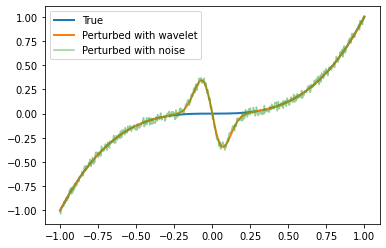

In [3]:
n_points = 500
x_low = -1
x_high = 1
x = np.linspace(-1, 1, n_points, dtype='float32')
y_true = np.power(x, 3)
y_wave = np.power(x, 3) - 8 * x * np.exp(-100 * np.square(x))
y_perturbed = y_wave + np.random.uniform(-0.05, 0.05, n_points)
fig, ax = plt.subplots()
ax.plot(x, y_true, linewidth=2.0)
ax.plot(x, y_wave, linewidth=2.0)
ax.plot(x, y_perturbed, alpha=0.5)
ax.legend(['True', 'Perturbed with wavelet', 'Perturbed with noise'])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(x, y_perturbed, test_size=0.33, random_state=42)

### 1-D Monotonic Regularizer

Custom training loop and penalization 

In [5]:
def train_step(trainable_model, dset, epoch=0, penal_param=1.0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        input_var = tf.Variable(x_batch, name='temp_input_var')
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_inner:
                tape_inner.watch(input_var)
                predictions = trainable_model(input_var, training=True)
            penal = penal_param * tf.reduce_sum(tf.math.maximum(-tape_inner.gradient(predictions, input_var), 0.0))
                # print(f'Gradient val: {tape.gradient(predictions, input_var)}')
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
            batch_penal[i] = penal.numpy()
            batch_loss[i] = loss_value.numpy()
        gradients = tape.gradient(loss_value, trainable_model.trainable_variables)
        trainable_model.optimizer.apply_gradients(zip(gradients, trainable_model.trainable_variables))
    return np.mean(batch_loss), np.mean(batch_penal)


def fit_model(trainable_model, X, y, epochs, batch=32, verbose=False, shuffle=False, penal_param=1.0):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    y = y[:, None]
    X = X[:, None]
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch)
    for i, epoch in enumerate(range(0, epochs)):
        losses[i], penalizations[i] = train_step(trainable_model, dset=dset, epoch=i, penal_param=penal_param)
        if verbose:
            print(f'Epoch:{i}/{epochs} Loss: {losses[i]}')
    return losses, penalizations

def unison_shuffled_copies(a, b):
    # shuffles the two arrays such that they preserve their feature order
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p, :], b[p]


class Penal:
    def __init__(self):
        pass
    
    def calc_penal(self):
        pass

In [6]:
architecture = [10, 10, 10]
modelnncust = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu') for a in architecture] + [tf.keras.layers.Dense(1, activation='linear')])
modelnncust.build(input_shape=(None,1))
modelnncust.compile(optimizer="Adam", loss="mse", metrics=["mae"])

epochs = 300
bs = 30
splits= 3

losses, penals = fit_model(modelnncust, X_train, y_train, epochs=epochs, batch=bs, verbose=False, shuffle=True,penal_param=1.0)

Text(0.5, 1.0, 'Penalizations')

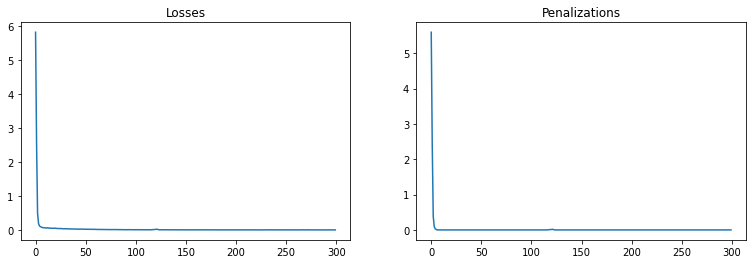

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(13,4))
ax[0].plot(losses)
ax[1].plot(penals)
ax[0].set_title('Losses')
ax[1].set_title('Penalizations')

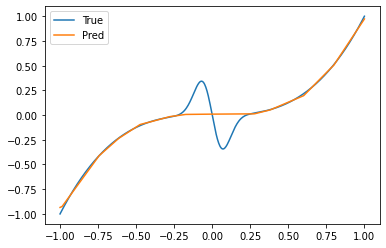

In [8]:
fix, ax = plt.subplots()

ax.plot(x, y_wave)
y_pred = modelnncust(x[:, None]).numpy().flatten()
ax.plot(x, y_pred)
ax.legend(['True', 'Pred'])
# ax[i].plot(x, y_wave)

In [9]:
v = tf.Variable(x[:, None], name='v_var')
with tf.GradientTape() as tape:
    tape.watch(v)
    model_vals = modelnncust(v)
print(len(tape.watched_variables())) 
model_grad = tape.gradient(model_vals, v)

9


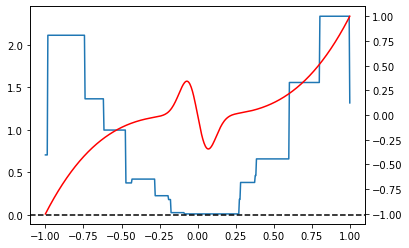

In [10]:
fig, ax = plt.subplots()
ax.plot(x, model_grad.numpy().flatten())
ax1= ax.twinx()
ax1.plot(x, y_wave, color='red')
ax.axhline(0, color='black', linestyle='--')

This works extremely well, for comparison try to remove the monotonicity condition and the function learnt is immediately bogus..

### Learning AAV for two actions using monotonic penalization

[INFO] [2021-04-20 14:05:59,704] [AAV] - Instantiated @ AAV


Text(0.5, 1.0, 'q(2)')

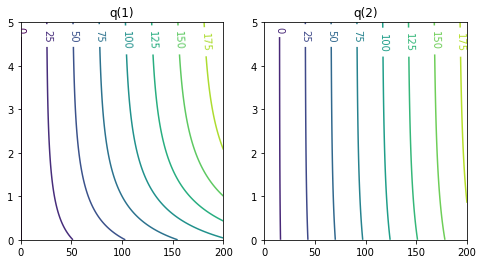

In [11]:
def plot_3d(x, y, z):
    z1 = z[:, 0]
    z2 = z[:, 1]
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z1 = griddata((x, y), z1, (grid_x, grid_y), method='cubic')
    grid_z2 = griddata((x, y), z2, (grid_x, grid_y), method='cubic')
    fig, ax = plt.subplots(ncols=2, nrows=1)
    CS = ax[0].contour(grid_x, grid_y, grid_z1)
    ax[0].clabel(CS, inline=1, fontsize=10)
    ax[0].set_title('spline q(1)')
    CS = ax[1].contour(grid_x, grid_y, grid_z2)
    ax[1].clabel(CS, inline=1, fontsize=10)
    ax[1].set_title('spline q(1)')
    
p = Parameters()
aav= AAV(p)
w_points = 200
l_points = 100
ws = np.linspace(0, 200, w_points)
ls = np.linspace(0, 5, l_points)
ww, ll = np.meshgrid(ws, ls)
z = np.zeros_like(ww)
zt = np.zeros_like(ww)
coord = []
targets = []
for i, wx in enumerate(ws):
    for j, ly in enumerate(ls):
        z[j, i] = -aav.u(ly, wx)
        zt[j, i] = -aav.u(ly + 3, wx) - 15
        #features.append([ly, wx, z[j, i], zt[j, i]])
        coord.append([ly, wx])
        targets.append([z[j, i], zt[j, i]])
coord = np.array(coord, dtype='float32')
targets = np.array(targets, dtype='float32')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(8,4))
CS = ax[0].contour(ww, ll, z)
ax[0].clabel(CS, inline=1, fontsize=10)
ax[0].set_title('q(1)')
CS = ax[1].contour(ww, ll, zt)
ax[1].clabel(CS, inline=1, fontsize=10)
ax[1].set_title('q(2)')

In [12]:
X2d_train, X2d_test, y2d_train, y2d_test = train_test_split(coord, targets, train_size=0.2)

In [17]:
model_in = tf.keras.Input(shape=(2,))
model_d1 = tf.keras.layers.Dense(64, activation='relu')(model_in)
model_d2 = tf.keras.layers.Dense(64, activation='relu')(model_d1)
model_d3 = tf.keras.layers.Dense(64, activation='relu')(model_d2)
model_d4 = tf.keras.layers.Dense(2)(model_d3)
model2d = tf.keras.Model(inputs=[model_in], outputs=[model_d4])
model2d.compile(loss='mse')
model2d.summary()

model2d_obj = [model2d, model2d.get_weights()]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 130       
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


In [18]:
def train_step_2d(trainable_model, dset, epoch=0):  
    batch_loss = np.zeros(len(dset))
    batch_penal = np.zeros(len(dset))
    batch_msme = np.zeros(len(dset))
    for i, (x_batch, y_batch) in enumerate(dset):
        input_var = tf.Variable(x_batch, name='temp_input_var')
        with tf.GradientTape() as tape:
            with tf.GradientTape() as tape_inner:
                tape.watch(input_var)
                predictions = trainable_model(input_var, training=True)
            penal = 1 * tf.reduce_sum(tf.math.maximum(-tape_inner.jacobian(predictions, input_var), 0.0))
            loss_value = tf.reduce_mean(tf.keras.losses.mean_squared_error(y_batch, predictions)) + penal
        gradients = tape.gradient(loss_value, trainable_model.trainable_variables)
        trainable_model.optimizer.apply_gradients(zip(gradients, trainable_model.trainable_variables))
        batch_penal[i] = penal.numpy()
        batch_loss[i] = loss_value.numpy()
        batch_msme = MSME2d(x_batch, trainable_model)
    return np.mean(batch_loss), np.mean(batch_penal), np.mean(batch_msme)


def fit_model_2d(trainable_model, X, y, epochs, batch_size=32, verbose=False, shuffle=False):
    losses = np.zeros(epochs)
    penalizations = np.zeros(epochs)
    msmes = np.zeros(epochs)
    if shuffle:
        #x, y = unison_shuffled_copies(x, y)
        dset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(len(y)).batch(batch_size)
    else:
        dset = tf.data.Dataset.from_tensor_slices((X,y)).batch(batch_size)
    for epoch in range(epochs):
        losses[epoch], penalizations[epoch], msmes[epoch] = train_step_2d(trainable_model, dset=dset, epoch=epoch)
        if verbose:
            print(f'Epoch:{epoch}/{epochs} Loss: {losses[epoch]}')
    return losses, penalizations, msmes


def unison_shuffled_copies(a, b):
    # shuffles the two arrays such that they preserve their feature order
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p, :], b[p]
   
    
def MSME2d(input_x, trained_model):
    # Mean Square Monotonicity Error (MSME)
    var_test = tf.Variable(input_x)
    with tf.GradientTape() as tape:
        tape.watch(var_test)
        preds = trained_model(var_test)
    jacob = tape.batch_jacobian(preds, var_test)
    return tf.reduce_sum(0.5 * tf.math.maximum(-jacob, 0.))


def continuous_training_loop_2d(modelobj, x_trn, y_trn, epochs, bs, training_splits=3):
    modeltotrn, weights = modelobj
    modeltotrn.set_weights(weights)
    fig, ax = plt.subplots(figsize=(15,6))
    train_epochs = int(epochs / training_splits)
    x_labels = np.arange(train_epochs, epochs + train_epochs, train_epochs)
    msme = []
    mse = []
    for i in range(training_splits):
        modeltotrn.fit(x_trn, y_trn, epochs=train_epochs, verbose=0, batch_size=bs, shuffle=True)
        y_pred = modeltotrn(x_trn).numpy()
        mse.append(tf.reduce_mean(tf.keras.losses.mean_squared_error(y_trn, y_pred)))
        msme.append(MSME2d(x_trn, modeltotrn))
    ax.plot(x_labels, mse, marker='x')
    ax1 = ax.twinx()
    ax1.plot(x_labels, msme, color='red', marker='x')
    ax.set_xlabel('Train steps')
    ax.legend(['MSE'], loc=2)
    ax1.legend(['MSME'], loc=1)
    ax.set_ylabel('MSE')
    ax1.set_ylabel('MSME')
    
    
def continuous_training_decorator(train_splits):
    # Decorates training loop
    def decorator(func):
        def wrapper(*args, **kwargs):
            fig, ax = plt.subplots(figsize=(15,6))
            mse = []
            msme = []
            penalizations = []
            for i in tqdm(range(train_splits)):
                losses, penalizations, msmes = func(*args, **kwargs)
                mse.append(losses[-1])
                # msme.append(penalizations[-1])
                msme.append(msmes[-1])

            ax.plot(mse, marker='x')
            ax1 = ax.twinx()
            ax1.plot(msme, color='green', marker='x')
            ax.set_xlabel('Train steps')
            ax.legend(['MSE'], loc=2)
            ax1.legend(['MSME'], loc=1)
            ax.set_ylabel('MSE')
            ax1.set_ylabel('MSME')
            return fig, ax
        return wrapper
    return decorator   

[WARNING] [2021-04-20 14:06:43,621] [tensorflow] - 5 out of the last 5 calls to <function pfor.<locals>.f at 0x000002E121FF59D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
[WARNING] [2021-04-20 14:06:43,920] [tensorflow] - 6 out of the last 6 calls to <function pfor.<locals>.f at 0x000002E121FF59D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repe

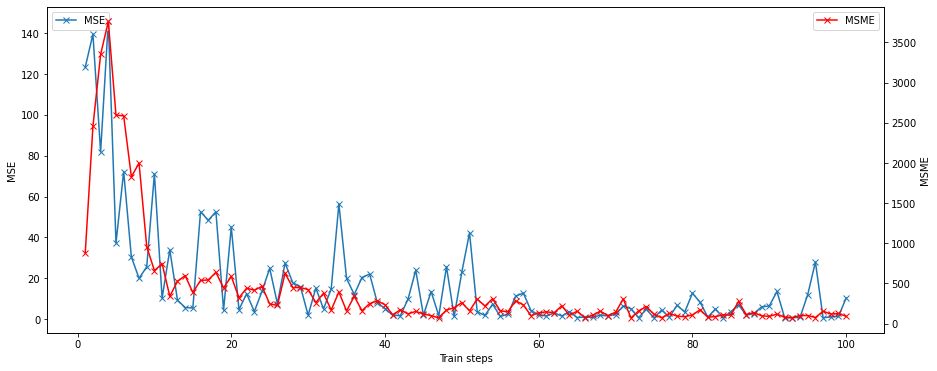

In [19]:
continuous_training_loop_2d(model2d_obj, X2d_train, y2d_train, epochs=100, bs=30, training_splits=100)

MSE: 10.240021705627441
MSME: 387.9819641113281


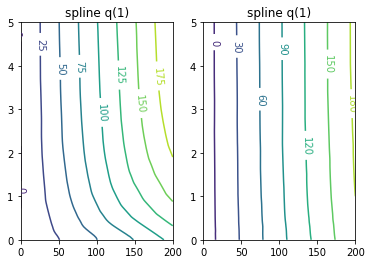

In [22]:
preds = model2d(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model2d)}')

In [26]:
model2d_p = tf.keras.models.clone_model(model2d)
model2d_p.set_weights(model2d_obj[1])
model2d_p.compile(loss='mse')
model2d_p_obj = [model2d_p, model2d_p.get_weights()]

losses, penalizations, msmes = fit_model_2d(model2d_p, X2d_train, y2d_train, epochs=100, batch_size=30, verbose=False, shuffle=False)

MSE: 11.789127349853516
MSME: 15.7808256149292


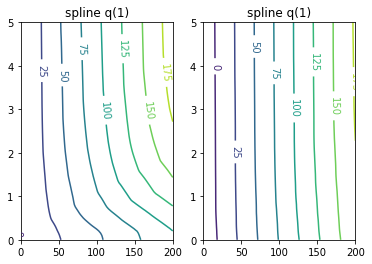

In [29]:
preds = model2d_p(X2d_test)
plot_3d(X2d_test[:, 1], X2d_test[:, 0], preds)
print(f'MSE: {tf.reduce_mean(tf.keras.losses.mean_squared_error(y2d_test, preds))}')
print(f'MSME: { MSME2d(X2d_test, model2d_p)}')

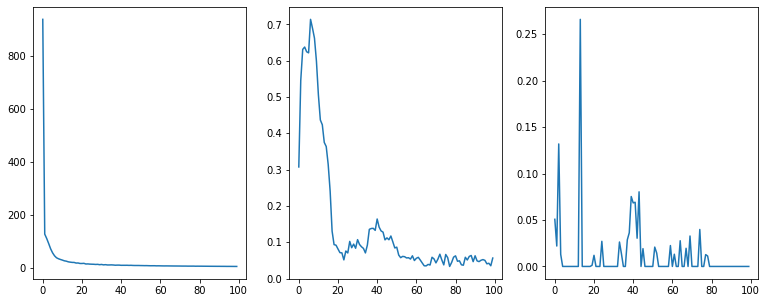

In [32]:
fig, ax = plt.subplots(ncols=3,figsize=(13,5))
ax[0].plot(losses)
ax[1].plot(penalizations)
ax[2].plot(msmes)

Jacobian penalty:

In [106]:
architecture = []
modeltest = tf.keras.Sequential([tf.keras.layers.Dense(a, activation='relu') for a in architecture] + [tf.keras.layers.Dense(2, activation='linear')])
modeltest.build(input_shape=(None, 2))
modeltest.compile(optimizer="Adam", loss="mse", metrics=["mae"])
modeltest.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 2)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [109]:
x_variable = tf.constant([[1.0, 2.0]])

In [110]:
modeltest.trainable_variables

[<tf.Variable 'dense_52/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.90610373, -0.8961023 ],
        [-0.06257081, -1.115424  ]], dtype=float32)>,
 <tf.Variable 'dense_52/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>]

In [111]:
modeltest(x_variable)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.7809621, -3.1269503]], dtype=float32)>

In [112]:
x_variable = tf.constant([[1.0, 2.0]])


with tf.GradientTape(persistent=True) as tape:
    tape.watch(x_variable)
    pred_variable = modeltest(x_variable)

dydw = tape.gradient(pred_variable, modeltest.trainable_variables)
dydx = tape.gradient(pred_variable, x_variable)
Jw = tape.jacobian(pred_variable, modeltest.trainable_variables)
Jx = tape.jacobian(pred_variable, x_variable)

In [113]:
dydw

[<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 1.],
        [2., 2.]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>]

In [114]:
dydx

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[ 0.01000142, -1.1779948 ]], dtype=float32)>

In [115]:
Jw

[<tf.Tensor: shape=(1, 2, 2, 2), dtype=float32, numpy=
 array([[[[1., 0.],
          [2., 0.]],
 
         [[0., 1.],
          [0., 2.]]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2, 2), dtype=float32, numpy=
 array([[[1., 0.],
         [0., 1.]]], dtype=float32)>]

In [116]:
Jx

<tf.Tensor: shape=(1, 2, 1, 2), dtype=float32, numpy=
array([[[[ 0.90610373, -0.06257081]],

        [[-0.8961023 , -1.115424  ]]]], dtype=float32)>